In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier,Pool,cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,f1_score

import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=17)

In [2]:
data=pd.read_parquet('/home/hashmi/Files/DataFolder/02_ParticleBoxData/DownstreamData.parquet')

In [3]:
data=data.drop(['track_charge'],axis=1)
data.head()

,track_chi2PerDoF,track_nLHCbIDs,track_p,track_phi,track_position_r,track_position_x,track_position_y,track_pt,track_tx,track_ty,track_pseudoRapidity,Downstream
0,0.070137,12.0,4719.268789,0.503917,760.736764,52.086334,758.951538,931.833411,0.176382,0.097257,2.305510,False
1,0.825198,11.0,5968.491193,3.117314,750.392212,-750.111389,20.527435,1308.485916,-0.224632,0.005455,2.198532,False
2,0.415610,12.0,4439.795650,2.678692,894.860060,-242.735580,861.309448,1041.913541,-0.216011,0.107804,2.128635,False
3,0.380737,11.0,2672.354020,0.031277,592.861337,580.054932,122.559540,962.754168,0.386009,0.012077,1.679913,False
4,0.637376,11.0,2802.582602,0.028834,943.479884,937.996155,101.575119,1098.949728,0.426080,0.012289,1.588467,False


In [4]:
# sample=data.sample(frac=0.1,random_state=46)
sample=data.copy()

In [5]:
x=sample.drop(['Downstream',],axis=1)
y=sample['Downstream'].map({True:1,False:0})

In [6]:
x,y=smote.fit_resample(x,y)
x_train,x_test,y_train,y_test=train_test_split(x,y,shuffle=True,stratify=y,random_state=29,test_size=0.3)
train_data=Pool(data=x_train,label=y_train)
test_data=Pool(data=x_test,label=y_test)
model=CatBoostClassifier(eval_metric='AUC',verbose=100,thread_count=10)

model.fit(x_train,y_train,eval_set=(x_test,y_test),plot=True,use_best_model=True)
y_predict=model.predict(x_test)
print("Accuracy Score : {}, ROC AUC Score : {}, F1 Score : {}".format(accuracy_score(y_test,y_predict),roc_auc_score(y_test,y_predict),f1_score(y_test,y_predict)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.313459
0:	test: 0.8163822	best: 0.8163822 (0)	total: 951ms	remaining: 15m 50s
100:	test: 0.8768473	best: 0.8768473 (100)	total: 1m 23s	remaining: 12m 19s
200:	test: 0.8852360	best: 0.8852360 (200)	total: 2m 42s	remaining: 10m 46s
300:	test: 0.8887527	best: 0.8887527 (300)	total: 4m 3s	remaining: 9m 24s
400:	test: 0.8909142	best: 0.8909142 (400)	total: 5m 23s	remaining: 8m 2s
500:	test: 0.8922518	best: 0.8922518 (500)	total: 6m 44s	remaining: 6m 42s
600:	test: 0.8933297	best: 0.8933297 (600)	total: 8m 5s	remaining: 5m 22s
700:	test: 0.8940917	best: 0.8940917 (700)	total: 9m 26s	remaining: 4m 1s
800:	test: 0.8947070	best: 0.8947070 (800)	total: 10m 47s	remaining: 2m 40s
900:	test: 0.8952840	best: 0.8952840 (900)	total: 12m 9s	remaining: 1m 20s
999:	test: 0.8957439	best: 0.8957439 (999)	total: 13m 30s	remaining: 0us

bestTest = 0.8957439243
bestIteration = 999

Accuracy Score : 0.803299266597068, ROC AUC Score : 0.803299266597068, F1 Score : 0.7983750692569066


In [7]:
model.save_model("./GhostClassifier.cpp",format="cpp",pool=train_data)

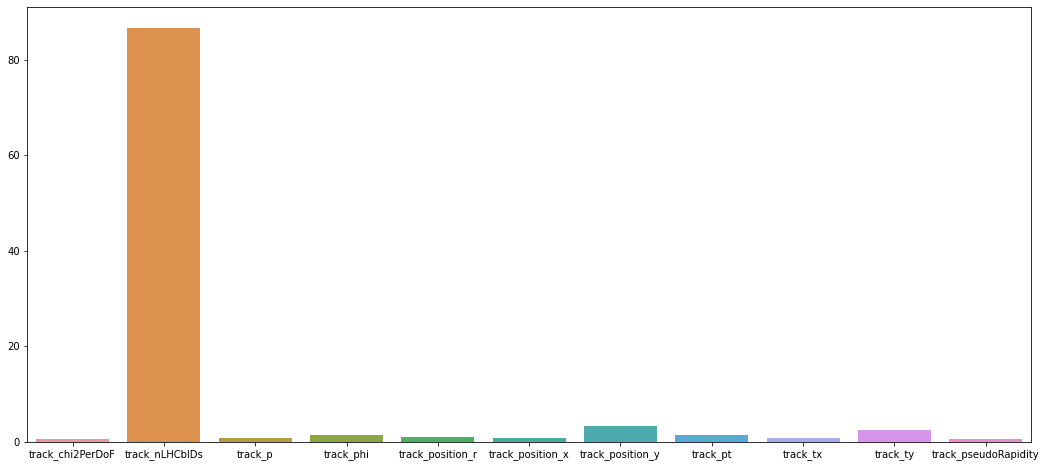

In [8]:
plt.figure(figsize=(18,8))
sns.barplot(x=x.columns,y=model.get_feature_importance())
plt.show()

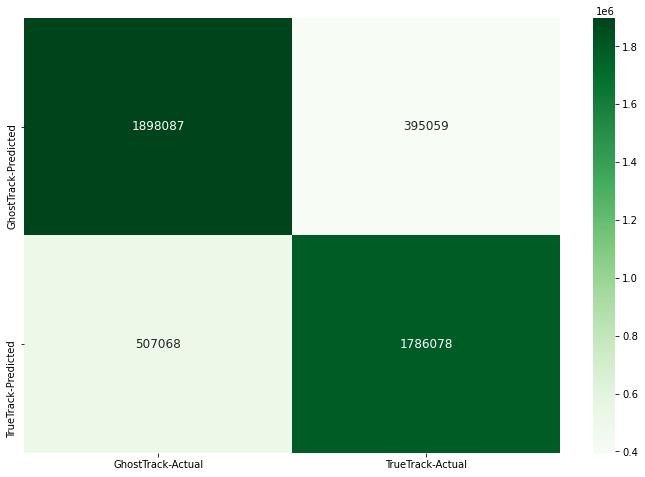

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test,y_predict),cmap='Greens',annot=True,fmt='d',xticklabels=['GhostTrack-Actual','TrueTrack-Actual'],yticklabels=['GhostTrack-Predicted','TrueTrack-Predicted'],annot_kws={'fontsize':12})
plt.show()

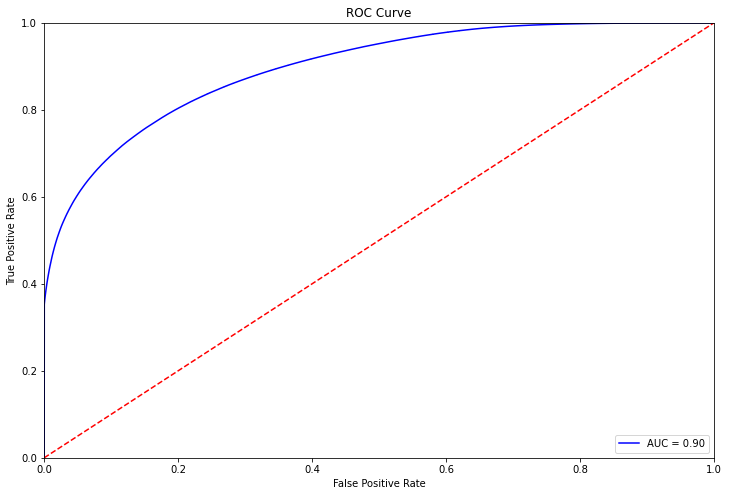

In [20]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()